# Lab 5
This lab will cover content from the fifth week of the course, including:
- Selection
- Trees
- Feature Importance

### Learning Objectives
- Interpret decision tree models to infer feature importances
- Compare feature importance information from regression models, PCA, and decision trees
- Visualize data in relevant spaces
- Select and justify use of supervised or unsupervised feature selection methods



### Submission And Assignment Instructions
Submit your `Lab5_lastname_firstname.ipynb` file on canvas with your answers clearly marked (✅) and code commented. Skeleton code and/or comments are provided throughout to help you.

Formatting Notes:
- ❓Questions you must answer or tasks are marked with a "❓"
- ✅ Answers you should give are marked with "✅ Answer:"
- *Helpful hints are usually given in italics*
- Code you need to write is marked with `## ❓YOUR CODE HERE`
  - ⭐ Bonus questions are marked with a "⭐"
  - 🍓 Bonus answers are marked with a "🍓"

**Please don't erase ANY of these markings!** They're to help the TAs find your answers and code as much as they're to help you find the questions.

## Section 1: Data Exploration

### 1.1: Load the Data

Run the code blocks below to load the dataset and turn the chemical [SMILES strings](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) into interpretable molecular descriptors. This is an example of featurizing (digitalizing) molecules using [RDKit descriptors](https://https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html), which describe the given molecule using one of over 200 molecular properties.

The y-data for these molecules is the hemotoxicity of the molecule.

*HemoTox dataset is from [here](https://github.com/RekerLab/DeepDelta/tree/main/Datasets/Benchmarks).*

In [1]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 30.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

#more datasets here: https://github.com/RekerLab/DeepDelta/tree/main/Datasets/Benchmarks
url = "https://raw.githubusercontent.com/RekerLab/DeepDelta/main/Datasets/Benchmarks/HemoTox.csv"
c = pd.read_csv(url)

# look at the top of this dataset
print(c.head())

# convert SMILES to molecules
mols = [Chem.MolFromSmiles(s) for s in c['SMILES']]

# create binary fingerprints for robust ML models
fps = np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(m,2)) for m in mols])

# create descriptors for ML models with higher interpretability
from rdkit.Chem import Descriptors
descr = Descriptors._descList
calc = [x[1] for x in descr]
d_name = [x[0] for x in descr]

desc = np.array([np.array([f(m) for f in calc]) for m in mols])

# Convert the numpy array to a pandas DataFrame with descriptor names as columns
X = pd.DataFrame(desc, columns=d_name)
# extract y values from original dataframe into separate vector
y = c['Y']
# have a look at the top of this dataframe
print(X.head())
print("Shape of the feature data: ", X.shape)

                                              SMILES      Y
0  CC(C)(C)c1cc(N)c(SCCN)c(NC(=O)c2cccc(C(=O)Nc3c...  1.146
1  COc1cc(OC)c(C(=O)Nc2cc(C(C)(C)C)cc(N)c2SCCN)cc...  2.161
2  CC(C)(C)c1cc(N)c(SCCN)c(NC(=O)c2cc(OCCN)cc(C(=...  2.037
3  CC(C)(C)c1cc(N)c(SCCNC(N)=[NH2+])c(NC(=O)c2cc(...  1.987
4  NCCSc1c(NC(=O)CCCCNC(N)=[NH2+])cc(C(F)(F)F)cc1...  1.786
   MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       13.468263       -0.344563          13.468263           0.169002   
1       13.926798       -0.479838          13.926798           0.142263   
2       13.814038       -0.425490          13.814038           0.207461   
3       14.119669       -0.485341          14.119669           0.035630   
4       14.127580       -4.926127          14.127580           0.012675   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  0.119644  608.878         564.526  608.296717                226.0   
1  0.097933  668.930         620.546  668.3

### 1.2: Data Exploration

It's important to consider how many observations (molecules) and features  you have in any new dataset. With many features over a relatively small set of observations, overfitting is very easy.

❓1.2.1 How many observations and features are in this dataset? Are there missing (NA) observations? Are there any features with 0 variance (only 1 unique value)? Remove missing observations and 0-variance features from your dataset, reporting how many observations and features you removed. *Hint: You can use `VarianceThreshold` to remove features with 0 variance.*

In [3]:
from sklearn.feature_selection import VarianceThreshold
##❓YOUR CODE HERE
missing_values = X.isna().sum().sum()
print(f"Number of missing values: {missing_values}")
X_clean = X.dropna()
print(f"Shape after removing missing values: {X_clean.shape}")
selector = VarianceThreshold(threshold=0)  # Remove features with 0 variance
X_clean_var = selector.fit_transform(X_clean)

print(f"Shape after removing 0-variance features: {X_clean_var.shape}")

obs_removed = X.shape[0] - X_clean.shape[0]
features_removed = X.shape[1] - X_clean_var.shape[1]
print(f"Number of observations removed: {obs_removed}")
print(f"Number of features removed: {features_removed}")

Number of missing values: 0
Shape after removing missing values: (828, 208)
Shape after removing 0-variance features: (828, 180)
Number of observations removed: 0
Number of features removed: 28


✅Answer:

We might want to understand how correlated these features are. With so many, they are difficult to visualize individually, but we can make a heatmap to understand whether these molecular descriptors are correlated. These correlations are summary statistics and may not perfectly show our data, but they can help give us an idea of what the data looks like.

❓1.2.2 Generate a heatmap using `sns.heatmap` to understand how the various molecular descriptors are correlated. To be able to see all the feature labels, you'll have to make the figure size very large.

*You may know from background outside the class that it's generally less informative to generate a heat map without clustering and you might be tempted to use `sns.clustermap`. For the purposes of this class, we haven't covered clustering yet, so just use `sns.heatmap`.*

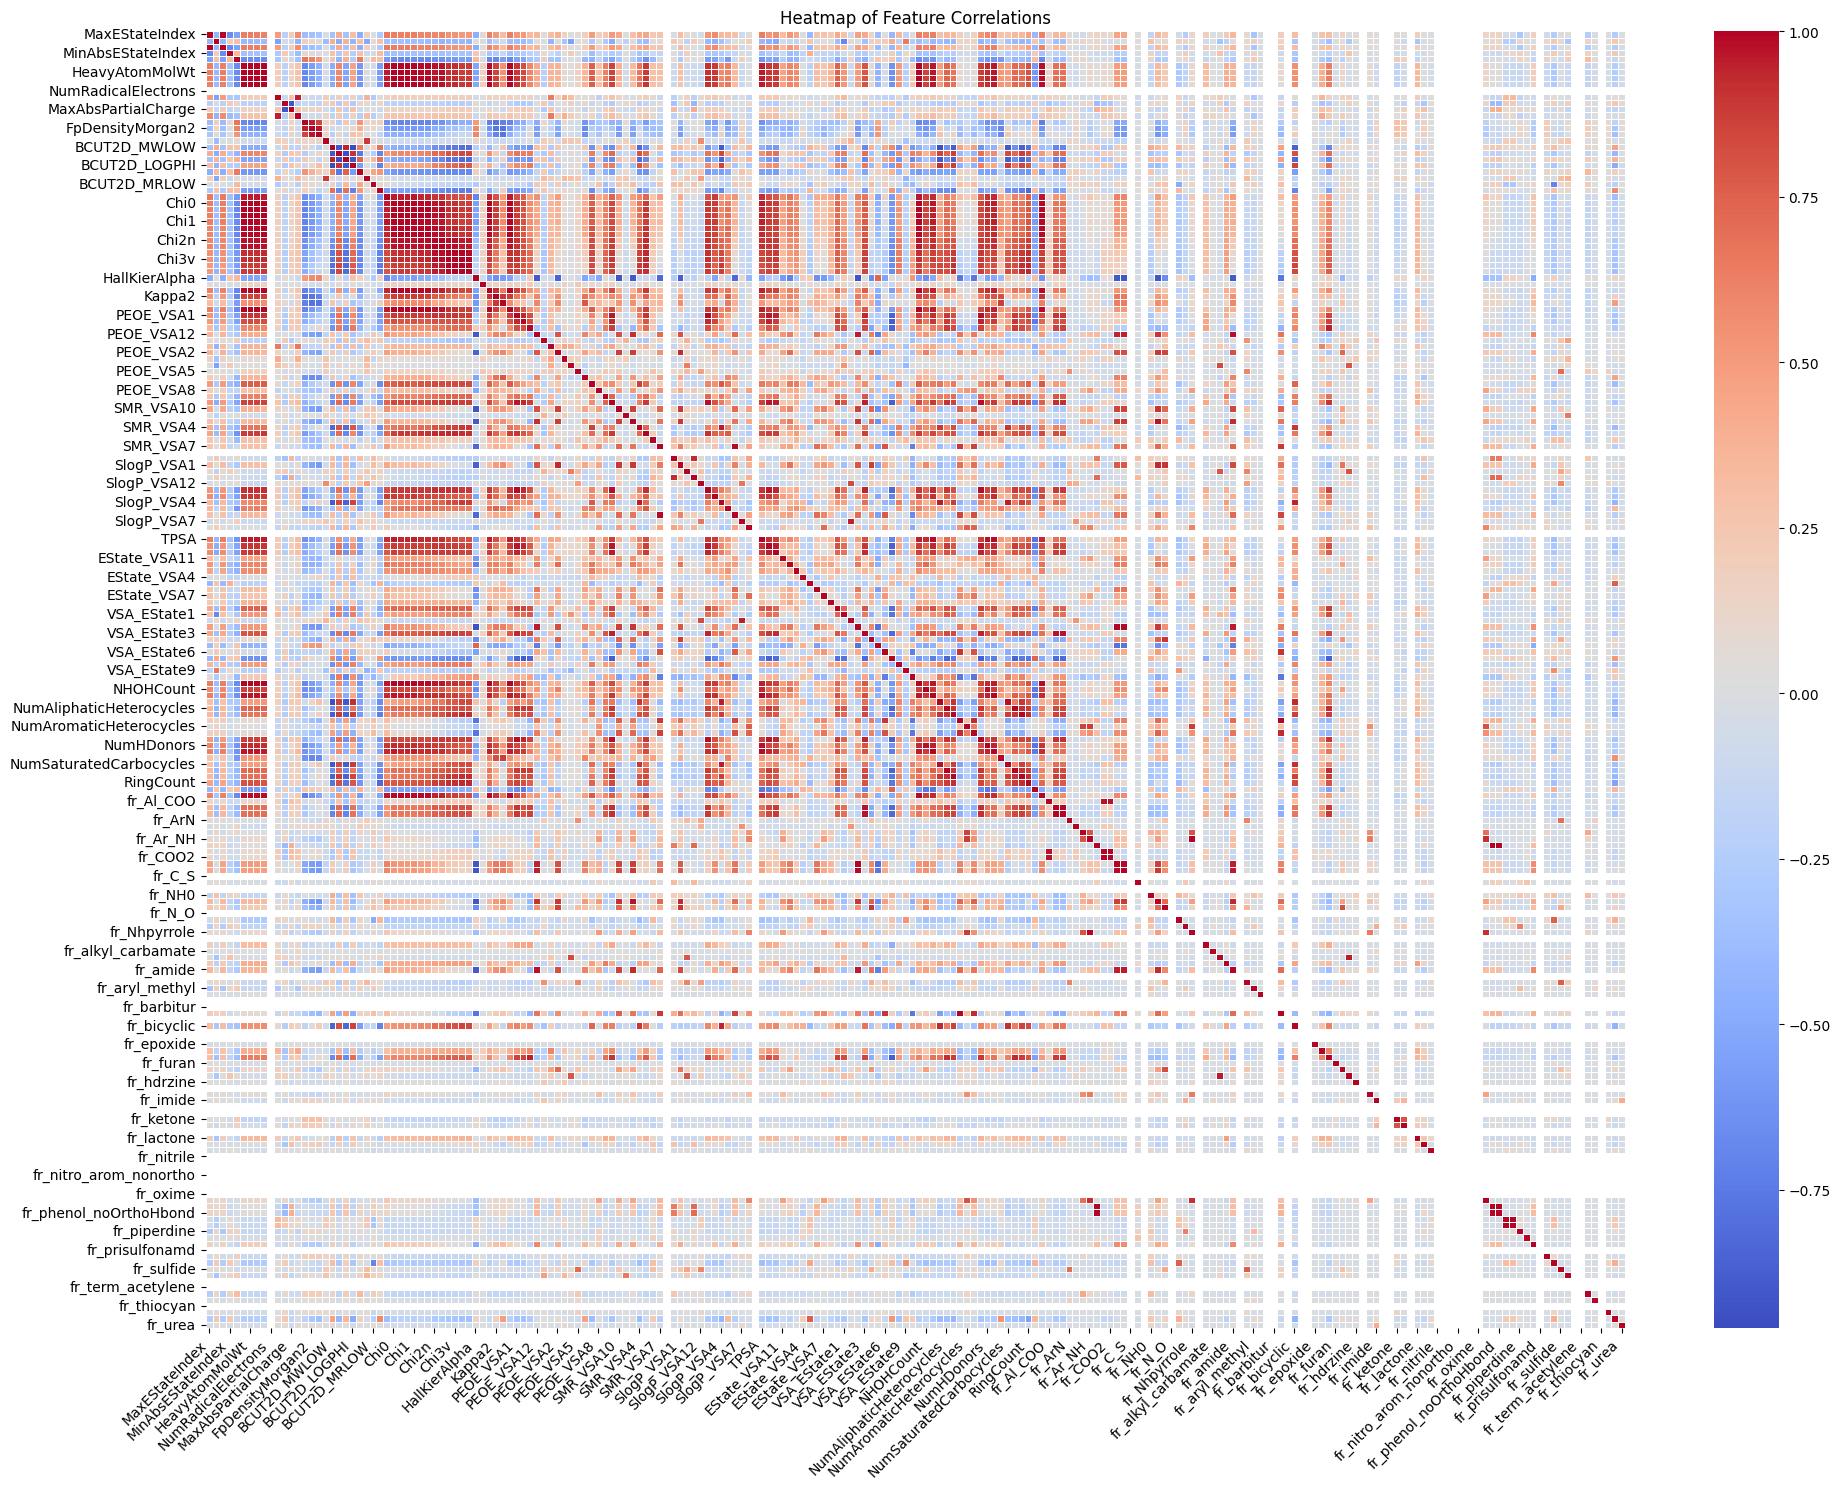

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

##❓YOUR CODE HERE

# calculate the correlation matrix
corr_matrix = X_clean.corr()

# plot the correlation matrix (using sns.heatmap)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Display the plot
plt.title('Heatmap of Feature Correlations')
plt.tight_layout()
plt.show()

## Section 2: PCA

In this section, we're going to visualize the data using PCA (it's generally good practice to visualize your data) and explore feature importances from PCA. PCA identifies orthogonal eigenvectors that represent directions of high variance in the dataset, using the covariance matrix. This matrix assumes our features are all centered on 0, so we will center and re-scale our features before doing PCA.

Each principal component (eigenvector) is a linear combination of the original features, and the coefficients of these combinations are known as loadings. By examining the loadings, one can identify which original features contribute most to the variance captured by each principal component. Features with high loadings on the first few principal components are usually considered more important, as they contribute significantly to the data's structure, or at least its variance.

When features are highly correlated, PCA tends to capture the variance of these correlated features in fewer principal components. This means that the first few principal components will explain a larger portion of the total variance, as they capture the common variance shared by the correlated features.



❓2.1 Write code below to standardize and scale your data, then do PCA. Visualize the first 3 principal components as an `sns.pairplot`. Label the axes on your pairplot as the percentage variation explained by that principal component. Be sure to adjust `alpha` to avoid overplotting.

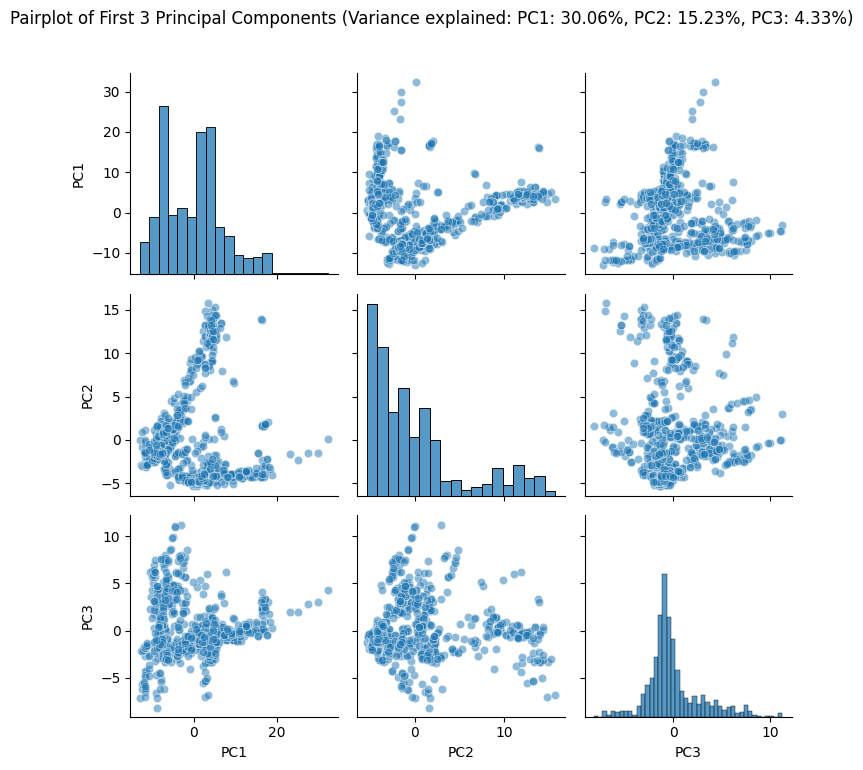

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

##❓YOUR CODE HERE

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# do PCA
pca = PCA(n_components=3)  # 3 componenets as mentioned for data viz
X_pca = pca.fit_transform(X_scaled)

# make a df for the PCA results
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(3)])

# get explained variance
explained_variance = pca.explained_variance_ratio_


## plotting
sns.pairplot(pca_df, plot_kws={'alpha': 0.5})
plt.suptitle(f'Pairplot of First 3 Principal Components (Variance explained: PC1: {explained_variance[0]:.2%}, '
             f'PC2: {explained_variance[1]:.2%}, PC3: {explained_variance[2]:.2%})', y=1.02)
plt.tight_layout()
plt.show()

Looking at the loadings on your principal components, especially components that explain substantial amounts of the variation in your dataset, can be helpful in identifying highly variable features, though these features may also be highly correlated.


❓2.2 Print the top 10 loadings on the first principal component, sorting by absolute value.

In [7]:
##❓YOUR CODE HERE

# get the loadings
loadings = pd.Series(pca.components_[0], index=X_clean.columns)

# sort and display the loadings
top_10_loadings = loadings.abs().sort_values(ascending=False).head(10)

print("Top 10 loadings on the first principal component:")
print(top_10_loadings)

Top 10 loadings on the first principal component:
Chi2n                  0.134237
Chi2v                  0.134165
NumValenceElectrons    0.132439
Chi3v                  0.132280
Chi3n                  0.132202
ExactMolWt             0.132059
MolWt                  0.132057
HeavyAtomMolWt         0.131952
Chi1v                  0.131233
HeavyAtomCount         0.131144
dtype: float64


## Section 3: Regularized Multiple Linear Regression - the LASSO

Unlike Ridge regression or simple multiple linear regression, L1 regularization (the LASSO) can set coefficients of features to 0, effectively selecting a subset of features as "important" for the model.

❓3.1 Use the start of the code below to build a simple linear regression model to predict the output, using L1 regularization (LASSO). How many coefficients does this model set equal to 0? Print the top 10 coefficients (top by absolute value). A test-train split has been established for you. Initialize the LASSO model with `alpha=0.1, random_state=42`.

In [8]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

##❓YOUR CODE HERE

# Initialize the Lasso model
lasso = Lasso(alpha=0.1, random_state=42)

# fit the model
lasso.fit(X_train, y_train)

# Get the coefficients and their corresponding feature names
coefficients = lasso.coef_
feature_names = X_clean.columns

# sort and display the top coefficients with their feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
top_10_coefficients = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)

# Print the top 10 features with the largest coefficients
print("Top 10 features with largest coefficients:")
print(top_10_coefficients)

Top 10 features with largest coefficients:
                      Feature  Coefficient
19               BCUT2D_CHGHI    -0.144847
118  NumSaturatedHeterocycles    -0.133519
177                fr_lactone    -0.131667
14           FpDensityMorgan1     0.112480
25                   BalabanJ     0.064812
64                   SMR_VSA5    -0.019528
102               VSA_EState9     0.013137
101               VSA_EState8    -0.009438
139                    fr_NH1    -0.000000
141                    fr_N_O     0.000000


How exciting! Our LASSO discarded a lot of features that it didn't find to be important. It could be that hemotoxicity is a function of just a few molecular features! Before we can conclude that, we should check to see if this model is actually a good fit for the data.

❓3.2 Does this model fit the data well? Make predictions on the test set and calculate the coefficient of determination ($R^2$) between the test predictions and test data. (1 sentence answer).
> *We'll revisit the LASSO to run cross-validation and compare to some decision trees later. This is just a first-pass check on one test data set.*

In [9]:
##❓YOUR CODE HERE
# Predict on the test set using the fitted model
y_pred = lasso.predict(X_test)

# Calculate the R^2 value and print
r2 = r2_score(y_test, y_pred)
# example of nice printing:)
print(f"R^2 value of the LASSO model on test data: {r2:.4f}")

R^2 value of the LASSO model on test data: 0.4543


✅Answer:

## Section 4: Decision Trees

❓4.1 Write code below to build and evaluate a simple decision tree on all the data, using 5-fold cross-validation. Use `random_state = 12` to seed the Decision tree. Print the RMSE plus or minus its standard error (not standard deviation) from the cross-validation.

In [10]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error

##❓YOUR CODE HERE

# Initialize and train the decision tree regressor using 5-fold cross-validation
model = DecisionTreeRegressor(random_state=12)

# run cv on the full model
cv_rmse = np.sqrt(-cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=5))

# print RMSE (nice printing example)
print(f"Cross-validated RMSE (full model): {cv_rmse.mean()} ± {cv_rmse.std()/np.sqrt(5)}")

Cross-validated RMSE (full model): 0.8271784844682276 ± 0.0395805921928604


If we try to visualize this model (using the code block below, which assumes your scaled dataframe is called `X_scaled`), you'll see that the very large number of features has made this model difficult to interpret, even if the tree organizes more important features to the top.

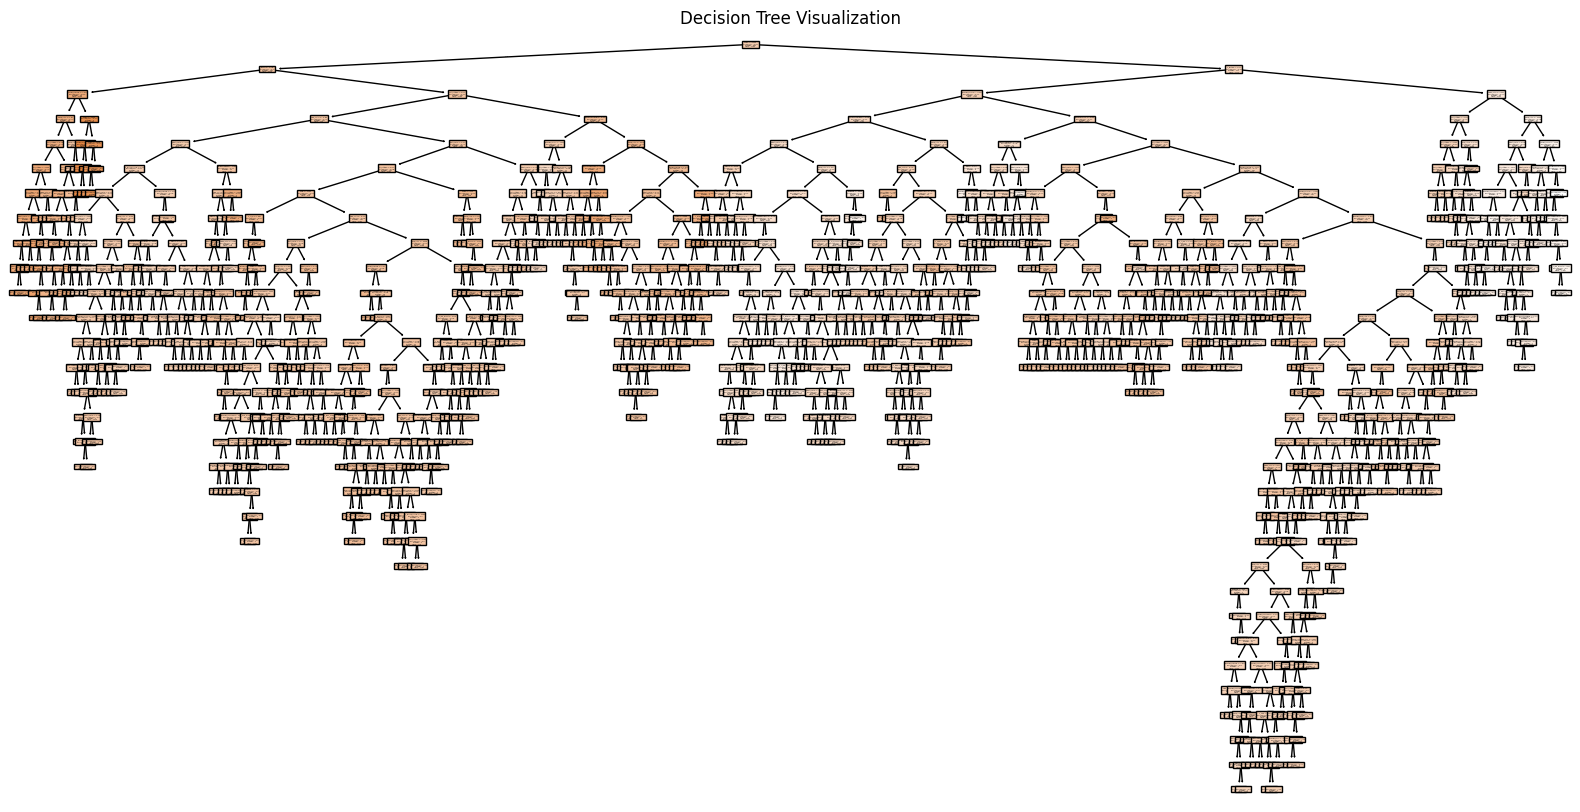

In [11]:
# Train the model on the entire dataset
model.fit(X_scaled, y)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

❓4.2 Build a second model, this time with all the features but a reduced depth (use `random_state=12, max_depth = 4`). Report the 5-fold cross-validation RMSE, plus or minus its standard error (not standard deviation). *Start naming your models and RMSEs different things, you're going to have to compare them later.*

In [12]:
##❓YOUR CODE HERE
# Build a model with a limited depth
model_shallow = DecisionTreeRegressor(random_state=12, max_depth=4)

# cv on the shallow model, using all the data
cv_rmse_shallow = np.sqrt(-cross_val_score(model_shallow, X_scaled, y, scoring='neg_mean_squared_error', cv=5))
print(f"Cross-validated RMSE (limited depth model): {cv_rmse_shallow.mean()} ± {cv_rmse_shallow.std()/np.sqrt(5)}")

Cross-validated RMSE (limited depth model): 0.7087052709376456 ± 0.06508121514089232


Note that this new model only uses some of the features because it is depth-limited. This limitation also makes it much easier to visualize! The codeblock below will run and show your decision tree, provided you've called your new model `model_shallow`.

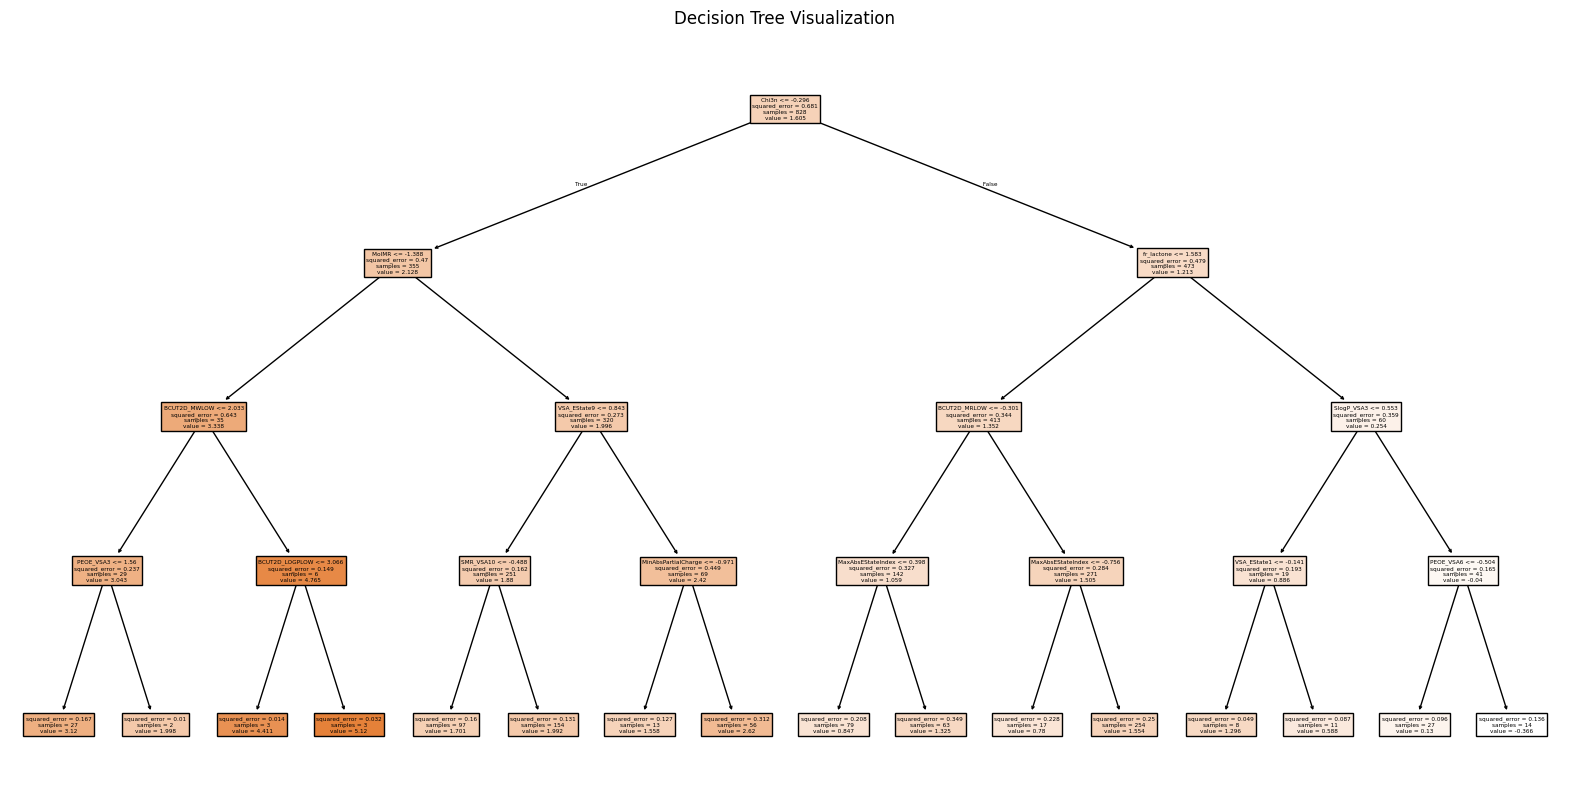

In [13]:
# fit the model on the entire dataset (not cross-validation)
model_shallow.fit(X_scaled, y)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(model_shallow, feature_names=X.columns, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

❓4.3 Why does this second model have a lower cross-validation error? (1-sentence answer)

✅ Answer:

The second model has a lower cross-validation error because limiting the depth of the tree prevents probably the overfitting, which improves generalization to unseen data.

❓4.4 Build a model with a reduced input feature set, using a Variance Threshold of 0.2 to remove low-variance features. Continue limiting the depth of the tree with `random_state=12, max_depth = 4`. Report the 5-fold cross-validation RMSE, plus or minus its standard error (not standard deviation).
> you can use `selected_features = selector.get_support(indices=True)` to get the feature names of the of the data left after selection.

In [14]:
##❓YOUR CODE HERE
# Build a second model with low-variance features removed
selector = VarianceThreshold(threshold=0.2)
X_reduced = selector.fit_transform(X_scaled)

# Initialize and train the reduced model using 5-fold cross-validation
model_reduced_shallow = DecisionTreeRegressor(random_state=12, max_depth=4)

# cv on the reduced model, using all the data
cv_rmse_reduced_shallow = np.sqrt(-cross_val_score(model_reduced_shallow, X_reduced, y, scoring='neg_mean_squared_error', cv=5))
print(f"Cross-validated RMSE (limited depth model with low var removed): {cv_rmse_reduced_shallow.mean()} ± {cv_rmse_reduced_shallow.std()/np.sqrt(5)}")

Cross-validated RMSE (limited depth model with low var removed): 0.6972903935157292 ± 0.057187536306668035


❓4.5 Use 5-fold cross-validation to compute RMSE and evaluate your LASSO model from earlier. Report the 5-fold cross-validation RMSE, plus or minus its standard error (not standard deviation).

In [17]:
##❓YOUR CODE HERE
# cross-validation, lasso is already defined above
cv_rmse_lasso = np.sqrt(-cross_val_score(lasso, X_scaled, y, scoring='neg_mean_squared_error', cv=5))
print(f"Cross-validated RMSE (lasso): {cv_rmse_lasso.mean()} ± {cv_rmse_lasso.std()/np.sqrt(5)}")

Cross-validated RMSE (lasso): 0.7146578384714735 ± 0.10837876059856172


❓4.6 Plot and compare all 4 models' RMSE with error bars (standard error).
> Your models should be the "Full Decision Tree", "Shallow Decision Tree", "Filtered Shallow Decision Tree" and "LASSO"

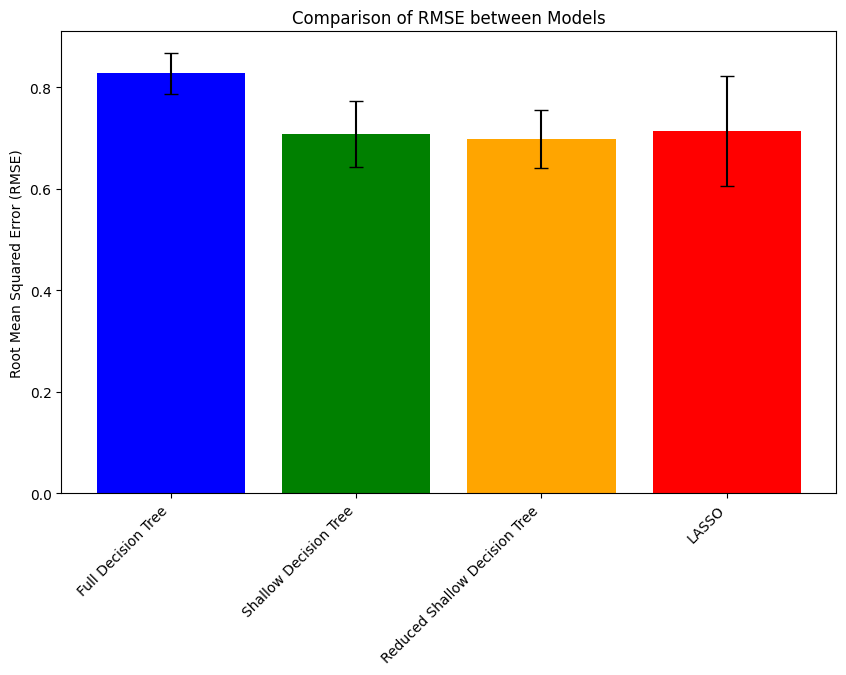

In [18]:
##❓YOUR CODE HERE
# Compare the models' RMSEs with error bars
model_names = ['Full Decision Tree', 'Shallow Decision Tree', 'Reduced Shallow Decision Tree', 'LASSO']

rmse_means = [
    cv_rmse.mean(),  # Full Decision Tree RMSE mean
    cv_rmse_shallow.mean(),  # Shallow Decision Tree RMSE mean
    cv_rmse_reduced_shallow.mean(),  # Reduced Shallow Decision Tree RMSE mean
    cv_rmse_lasso.mean()  # LASSO RMSE mean
]

rmse_errors = [
    cv_rmse.std() / np.sqrt(5),  # Full Decision Tree standard error
    cv_rmse_shallow.std() / np.sqrt(5),  # Shallow Decision Tree standard error
    cv_rmse_reduced_shallow.std() / np.sqrt(5),  # Reduced Shallow Decision Tree standard error
    cv_rmse_lasso.std() / np.sqrt(5)  # LASSO standard error
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_means, yerr=rmse_errors, capsize=5, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE between Models')
plt.xticks(rotation=45, ha='right')
plt.show()

❓4.7 Was there a significant change in model performance when you compare using all the data to using just a subset of the data (with the same `max_depth = 4` parameter)? Why or why not? *Hint: Both of these limited-depth trees have used "early stopping" to avoid overfitting. Generally, what variables are these trees using to make decisions?*

> *You should not have to do a statistical test to see whether or not there was a significant difference between these two conditions, it should be obvious from looking at your plot.*

✅Answer:

The bar plot shows that the Full Decision Tree has the highest RMSE, meaning it performs the worst, likely due to overfitting with too many features. The Shallow Decision Tree and Reduced Shallow Decision Tree have lower RMSEs, with very similar performance (no significant difference). This suggests that limiting the tree depth to 4 helps prevent overfitting, and removing low-variance features doesn't significantly change the model's accuracy. The LASSO model also performs similarly, with an RMSE close to the shallow trees, indicating that it too effectively reduces unnecessary complexity by shrinking some coefficients to zero.

❓4.8 Were any of these good models? Since RMSE has the same units as the response variable (like standard deviation does), compare the RMSE to the scale of the data by making a histogram and/or boxplot of the response variable to understand if RMSE around 0.7 is reasonable, given the scale of the data.

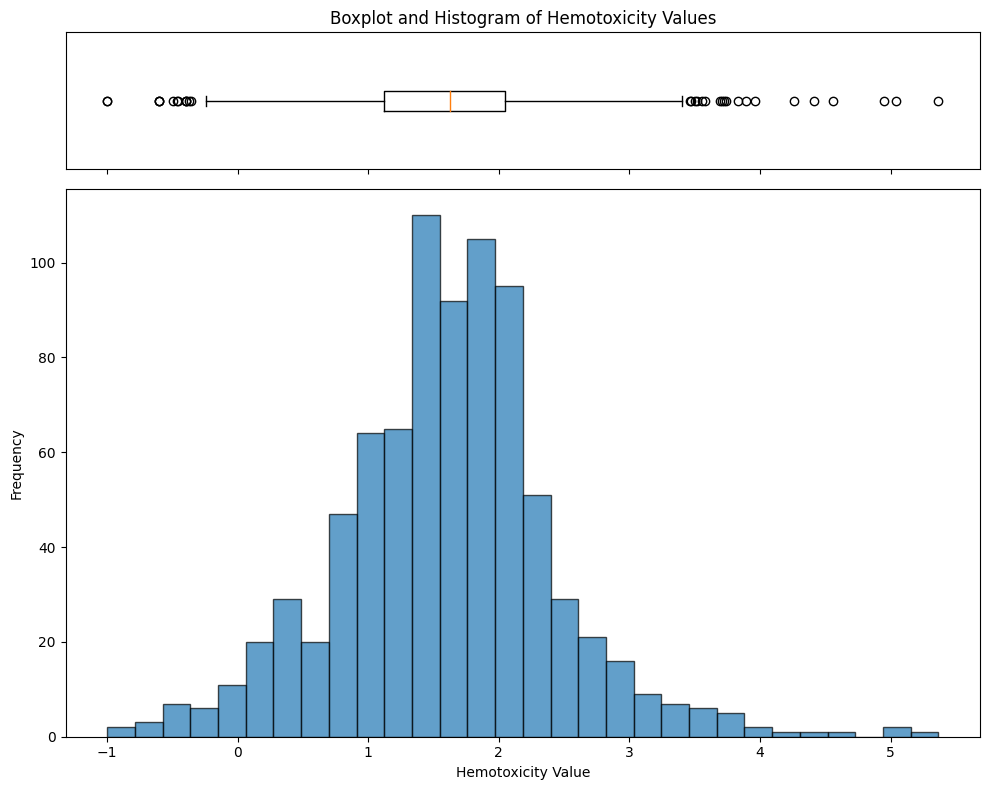

In [ ]:
##❓TA CODE HERE

# output from TAs left here so you can see what the scale of hemotoxicity values should be
# and what sort of graph we're asking for here
# fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True,
#                                      gridspec_kw={"height_ratios": [1, 5]},
#                                      figsize=(10, 8))

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


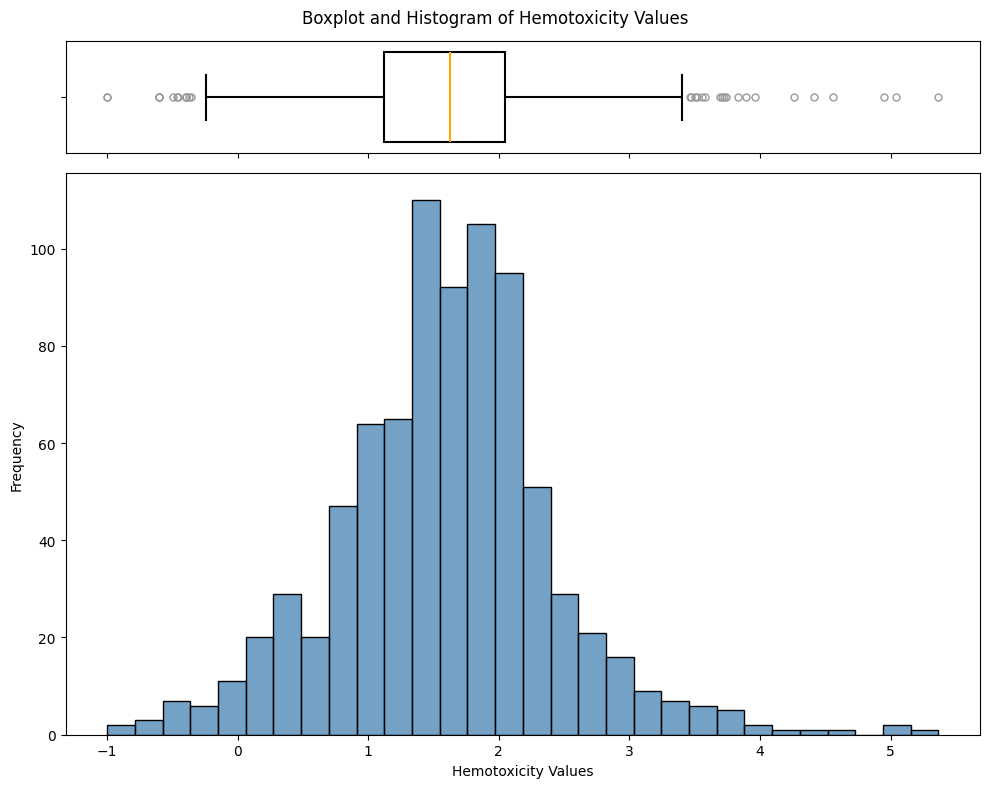

In [27]:
##❓MY (Srikar) CODE HERE

fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": [1, 5]}, figsize=(10, 8))
sns.boxplot(x=y, ax=ax_box, color='white', linewidth=1.5, fliersize=5, boxprops={'edgecolor': 'black'},
            medianprops={'color': 'orange'}, whiskerprops={'color': 'black'}, capprops={'color': 'black'}) # got ai's help here to match the ta plot format hehe
ax_box.set_facecolor('white')  # Ensure the background is white
sns.histplot(x=y, bins=30, ax=ax_hist, kde=False, color='steelblue')
ax_box.set(xlabel='')
ax_hist.set_xlabel('Hemotoxicity Values')
ax_hist.set_ylabel('Frequency')
fig.suptitle('Boxplot and Histogram of Hemotoxicity Values')
plt.tight_layout()
plt.show()




✅Answer (~1 sentence):

Since the hemotoxicity values range from -2.0 to 2.0, an RMSE of 0.7 means the error is about 17.5% of the entire range. This shows that none of the models are super duper accurate, as the error is quite large compared to the scale of the data.

## Section 5: Math - Node impurities

In the regression case, decision trees can minimize mean squared error between the predicted response value and the true response value. In the classification case, the "error" is slightly more complicated.

We're going to calculate some node impurities by hand! **Please show all your work for this section. Submit typeset or clear handwritten work.**

We're going to look at a toy dataset of apples and bananas, each of which has an associated color and weight. In this scenario, we're trying to predict the type of fruit based on its properties.

| Weight (g) | Color | Type   |
|------------|-------|--------|
| 155        | green   | Apple  |
| 132        | red     | Apple  |
| 175        | yellow  | Banana |
| 152        | green   | Banana |
| 141        | *yellow*  | Apple  |
| 170        | yellow  | Banana |




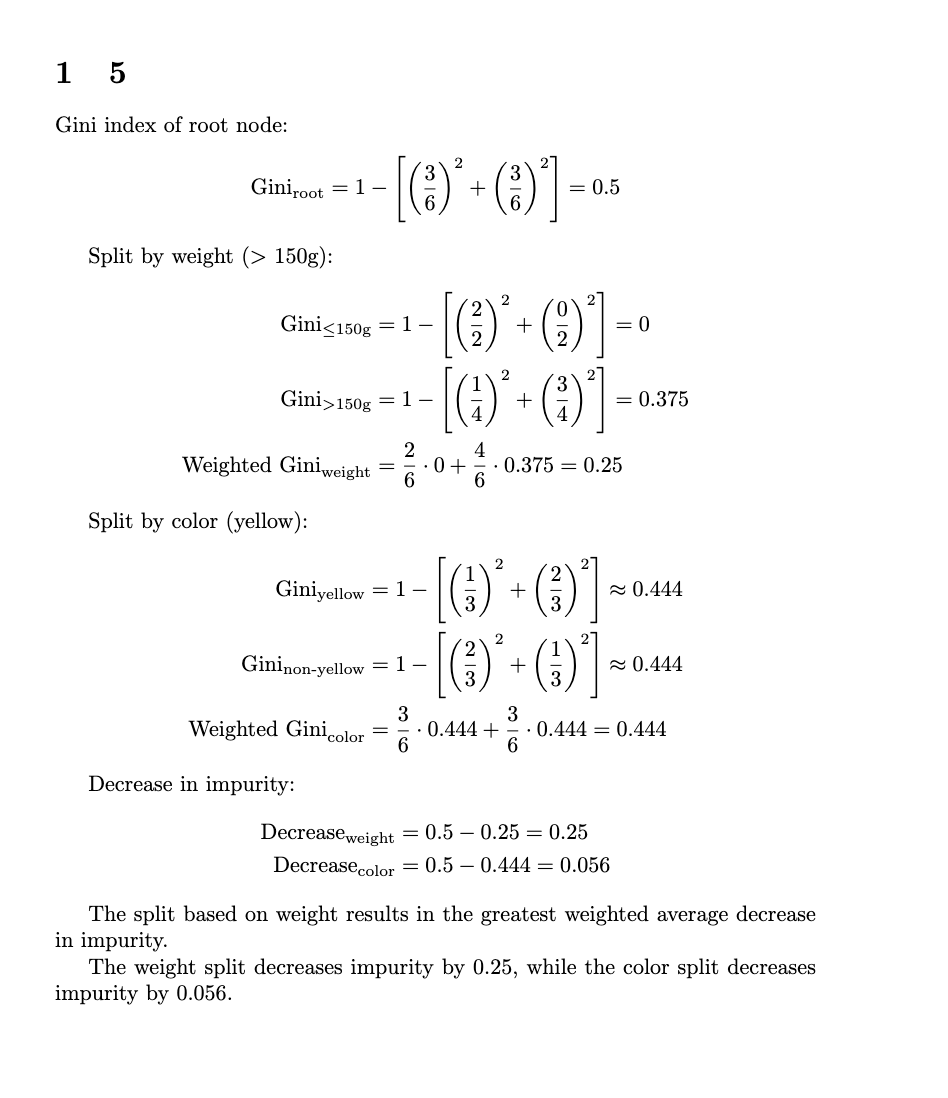

❓5.1 Calculate the gini index (also called impurity) of the root node (all the samples).

✅Answer:

❓5.2 Split the fruits by whether or not their weight is greater than 150 g and calculate the Gini index for both resulting nodes.

✅Answer:

Node 1 (<=150 g):

Node 2 (>150 g):

❓5.3 Split the fruits by whether or not they're yellow and calculate the Gini index for both resulting nodes.

✅Answer:
> Node 1 (yellow):

> Node 2 (non-yellow):

❓5.4 Which split results in the greatest weighted average decrease in impurity?

✅Answer: